In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

file_path = '../gtsrb-german-traffic-sign/Train.csv'
data = pd.read_csv(file_path)

# Filter for specific classes
classes_of_interest = [14,39] 
data = data[data['ClassId'].isin(classes_of_interest)]

print(data.head())
unique_classes = sorted(data['ClassId'].unique())
print("Unique classes in the dataset:", unique_classes)
print(data.shape)


       Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
22620     48      45       6       5      43      40       14   
22621     48      46       6       6      43      41       14   
22622     49      46       5       6      44      41       14   
22623     51      49       5       6      46      44       14   
22624     50      48       5       5      45      43       14   

                                 Path  
22620  Train/14/00014_00000_00000.png  
22621  Train/14/00014_00000_00001.png  
22622  Train/14/00014_00000_00002.png  
22623  Train/14/00014_00000_00003.png  
22624  Train/14/00014_00000_00004.png  
Unique classes in the dataset: [14, 39]
(1080, 8)


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=11):
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)  # Batch normalization for first conv layer
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)  # Batch normalization for second conv layer
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)  # Batch normalization for third conv layer
        
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 4 * 4, 1024)  # Adjusted size assuming input size of 32x32
        self.dropout1 = nn.Dropout(0.5)  # Dropout before the first fully connected layer
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        # Applying convolutions, batch norm, pooling, and ReLU
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Conv1 -> BatchNorm1 -> ReLU -> Pool
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Conv2 -> BatchNorm2 -> ReLU -> Pool
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Conv3 -> BatchNorm3 -> ReLU -> Pool
        
        # Flatten the output for the dense layers
        x = x.view(-1, 256 * 4 * 4)
        
        # Applying first fully connected layer, dropout, and ReLU
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)  # Apply dropout after activation
        
        # Output layer
        x = self.fc2(x)
        return x


In [14]:
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, Resize, ToTensor, RandomAffine
from torch.utils.data import DataLoader, Subset, Dataset
from PIL import Image
import cv2

# Split data into train, val, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['ClassId'])
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42, stratify=train_data['ClassId'])

transform = Compose([
    RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.0)),
    Resize((32, 32)),  # Resize to 32x32 pixels
    ToTensor()         
])

# Dataset classes
class GTSRBEdgeDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.dataframe.iloc[idx]['Path'])
        try:
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                raise FileNotFoundError(f"Image not found at {img_path}")
            edges = cv2.Canny(image, 100, 200)
            edges = Image.fromarray(edges)
            
            if self.transform:
                edges = self.transform(edges)
            label = self.dataframe.iloc[idx]['ClassId']
            return edges, label
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Handle corrupted file by returning the next one
            return self.__getitem__((idx + 1) % len(self))

# Create datasets
train_dataset = GTSRBEdgeDataset(train_data, root_dir='../gtsrb-german-traffic-sign/', transform=transform)
val_dataset = GTSRBEdgeDataset(val_data, root_dir='../gtsrb-german-traffic-sign/', transform=transform)
test_dataset = GTSRBEdgeDataset(test_data, root_dir='../gtsrb-german-traffic-sign/', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Class 14 has 3 images collected.
Class 39 has 3 images collected.


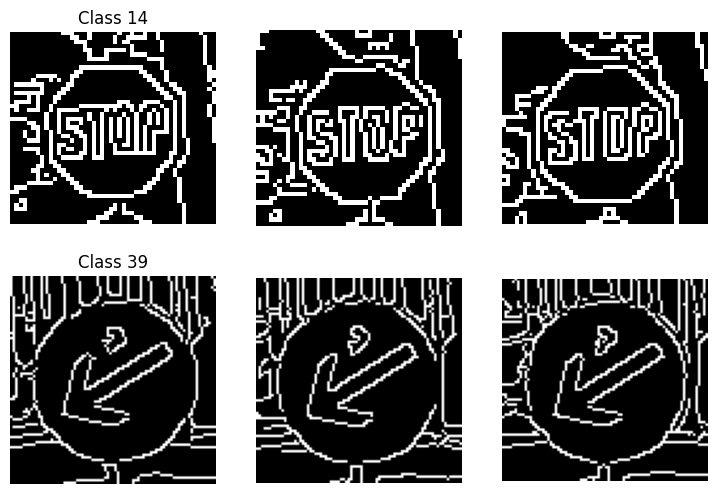

In [15]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor

def show_images(dataframe, root_dir, num_images=3):
    transform = ToTensor()  # Transform to convert images to tensor
    dataset = GTSRBEdgeDataset(dataframe, root_dir, transform=transform)
    
    # Collect three images per class
    images_per_class = {cls: [] for cls in classes_of_interest}  # Initialize lists for each class
    for image, label in dataset:
        if len(images_per_class[label]) < num_images:
            images_per_class[label].append(image)
        # Check if all classes have enough images
        if all(len(imgs) == num_images for imgs in images_per_class.values()):
            break

    # Diagnostic print to check the collected images per class
    for cls, imgs in images_per_class.items():
        print(f'Class {cls} has {len(imgs)} images collected.')

    # Plotting
    num_classes = len(images_per_class)
    fig, axs = plt.subplots(num_classes, num_images, figsize=(num_images * 3, num_classes * 3), squeeze=False)
    class_indices = {cls: idx for idx, cls in enumerate(sorted(images_per_class.keys()))}  # Map class IDs to subplot indices

    for class_id, images in images_per_class.items():
        class_idx = class_indices[class_id]  # Get the subplot index for the current class ID
        for i, image in enumerate(images):
            ax = axs[class_idx][i]  # Use class_idx to access axs
            ax.imshow(image.squeeze(0), cmap='gray')  # Assuming image is in (1, H, W) shape
            ax.axis('off')
            if i == 0:
                ax.set_title(f'Class {class_id}')
    plt.show()

# Call the function with appropriate parameters
show_images(data, '../gtsrb-german-traffic-sign/')


In [16]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)
model = SimpleCNN(num_classes=11) 
model.to(device)  


mps


SimpleCNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=11, bias=True)
)

In [17]:
import torch.optim as optim
from torch.nn.functional import cross_entropy

optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        # print(images.size(0), labels.size(0))
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = cross_entropy(outputs, labels)
        # print("Outputs:", outputs)
        # print("Labels:", labels)
        # print("Loss:", loss.item())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Epoch {epoch+1}, Training Loss: {running_loss / len(train_loader)}, Validation Accuracy: {100 * correct / total}%')


Epoch 1, Training Loss: 0.0, Validation Accuracy: 0.0%
Epoch 2, Training Loss: 0.0, Validation Accuracy: 0.0%
Epoch 3, Training Loss: 0.0, Validation Accuracy: 0.0%
Epoch 4, Training Loss: 0.0, Validation Accuracy: 0.0%
Epoch 5, Training Loss: 0.0, Validation Accuracy: 0.0%
Epoch 6, Training Loss: 0.0, Validation Accuracy: 0.0%
Epoch 7, Training Loss: 0.0, Validation Accuracy: 0.0%
Epoch 8, Training Loss: 0.0, Validation Accuracy: 0.0%
Epoch 9, Training Loss: 0.0, Validation Accuracy: 0.0%
Epoch 10, Training Loss: 0.0, Validation Accuracy: 0.0%
Epoch 11, Training Loss: 0.0, Validation Accuracy: 0.0%
Epoch 12, Training Loss: 0.0, Validation Accuracy: 0.0%
Epoch 13, Training Loss: 0.0, Validation Accuracy: 0.0%
Epoch 14, Training Loss: 0.0, Validation Accuracy: 0.0%


KeyboardInterrupt: 

Test Accuracy: 0.3796768707482993
F1 Score: 0.16416039428129522


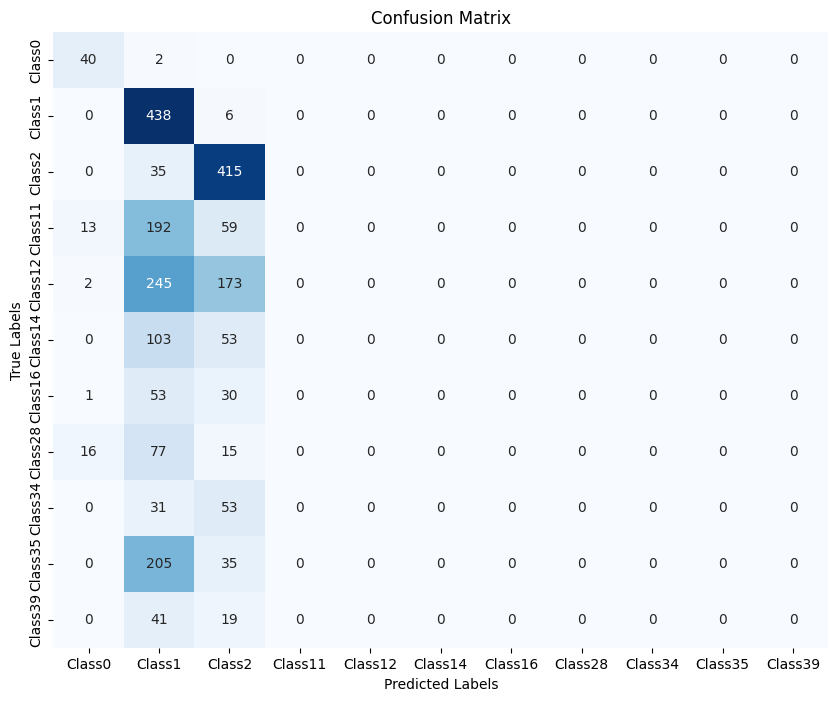

In [48]:
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
import seaborn as sns
y_pred = []
y_true = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

def plot_confusion_matrix(cm, class_names):
    """
    Creates a heatmap from a numpy confusion matrix.
    
    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
    fig, ax = plt.subplots(figsize=(10, 8))  # Adjust size as necessary
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    ax.set_title('Confusion Matrix')

    plt.show()

print(f'Test Accuracy: {accuracy_score(y_true, y_pred)}')
print(f'F1 Score: {f1_score(y_true, y_pred, average="macro")}')
class_names = ['Class0', 'Class1', 'Class2', 'Class11', 'Class12', 'Class14', 'Class16', 'Class28', 'Class34', 'Class35', 'Class39'] 
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, class_names)

